In [1]:
%matplotlib inline

import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46427/status,
Dashboard: /proxy/46427/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46789,Workers: 4
Dashboard: /proxy/46427/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://10.6.121.6:42435,Total threads: 2
Dashboard: /proxy/37589/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33759,


## Potential bug in MoM5 code?

Through the following analysis, we highlight a potential bug in the calculation of shortwave radiation in MOM5 and its four components - (i) visible direct, (ii) visible diffuse, (iii) near-infrared direct, and (iv) near-infrared diffuse. These four fluxes add up to become the shortwave radiation. We suspect that there is an unintended cell shift while converting from shortwave flux (which is provided as an input to ACCESS-OM2) to the four types of shortwave fluxes.

We are trying to run a MoM-solo simulation where we only have prescribed fluxes, applied as boundary conditions. Strangely, the MOM-solo model requires us to provide the four shortwave fluxes individually. We use the diagnostics from a control ACCESS-OM2 simulation for this purpose. However, there are issues in the individual shortwave flux diagnostics which need to be resolved.

Here, we have three versions of the four shortwave fluxes:
1. Input to a flux-based MOM- solo model, which requires the four shortwave fluxes separately,
2. Output of the flux-based model, and
3. Diagnostics of a control ACCESS-OM2 model for the four fluxes and the shortwave radiation.

More details are given after the figure comparison.

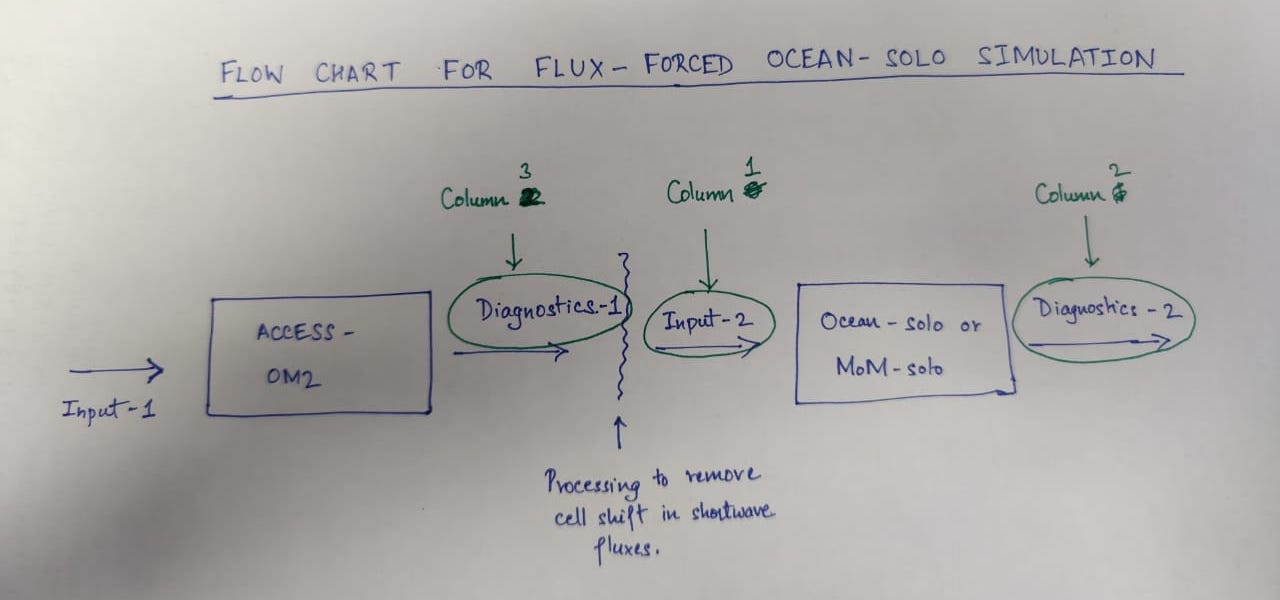

In [3]:
db = '/scratch/x77/db6174/mom/archive/databases/1deg_jra55_ryf/cc_database_flux_forced_attempt3.db'
session_ffa3 = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_vary_KPP_extended.db'
session_cont = cc.database.create_session(db)

session = [session_ffa3, session_cont]
expt = ['1deg_jra55_ryf_flux_forced_attempt3', '1deg_jra55_ryf_param_KPP_extended']

In [4]:
st = ['1900-01-01', '2000-01-01']
et = ['1900-01-05', '2004-12-31']

In [5]:
ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

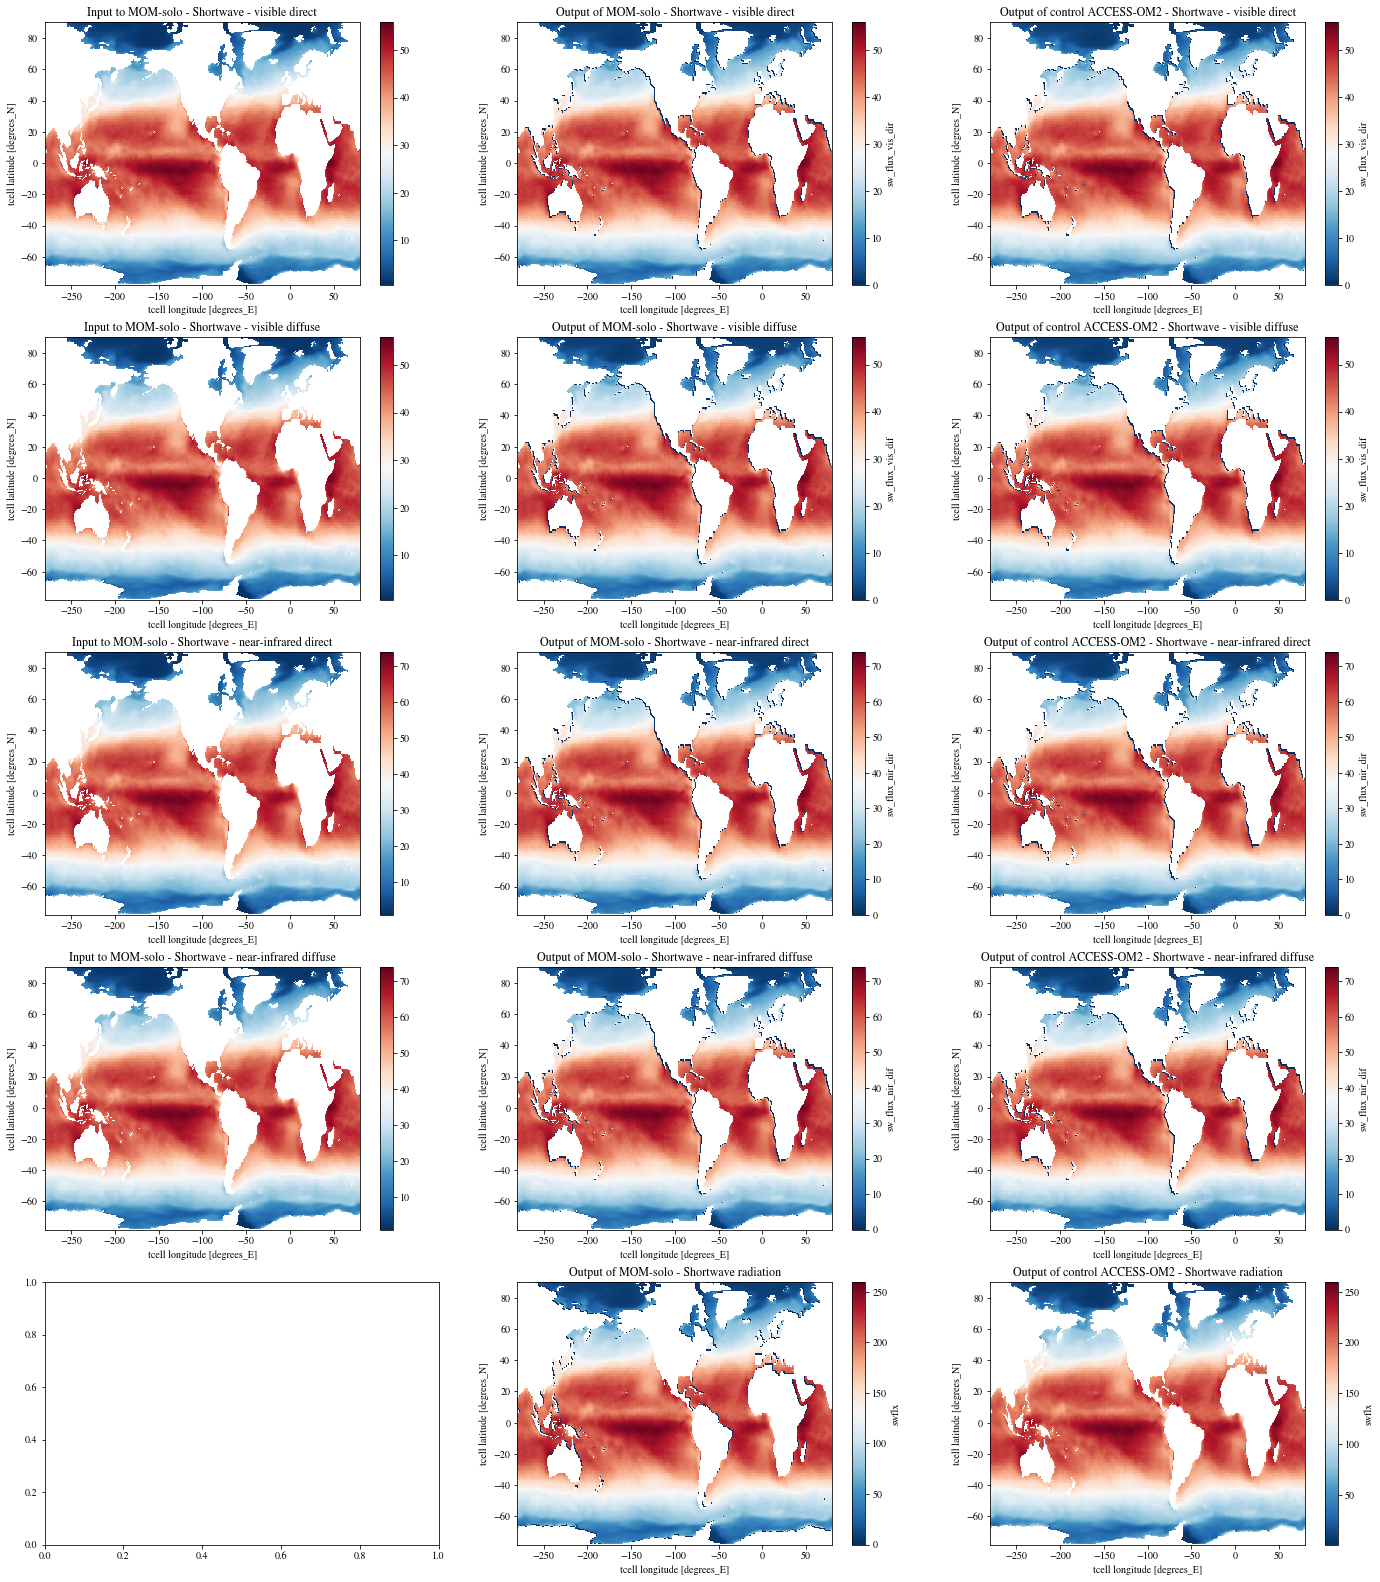

In [6]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (24, 28))

var_list = ['sw_flux_vis_dir', 'sw_flux_vis_dif', 'sw_flux_nir_dir', 'sw_flux_nir_dif', 'swflx']

var_name = ['Shortwave - visible direct', 'Shortwave - visible diffuse', 'Shortwave - near-infrared direct', 
            'Shortwave - near-infrared diffuse', 'Shortwave radiation']

for i, j in enumerate(var_list):
    var_ffa2 = cc.querying.getvar(expt = expt[0], session = session[0], variable = j, frequency = '1 daily').mean('time')
    var_cont = cc.querying.getvar(expt = expt[1], session = session[1], variable = j, frequency = '1 monthly').mean('time')
    
    if(j!= 'swflx'):
        nc_file = '/scratch/x77/db6174/1deg_inputs/flux_forced_attempt3/' + j + '_new.nc'
        xr.open_dataset(nc_file).to_array().mean('time').mean('variable').plot(ax = axes[i][0], cmap = 'RdBu_r')
        axes[i][0].set_title('Input to MOM-solo - ' + var_name[i])
    
    var_ffa2.plot(ax = axes[i][1], cmap = 'RdBu_r')
    axes[i][1].set_title('Output of MOM-solo - ' + var_name[i])
    var_cont.plot(ax = axes[i][2], cmap = 'RdBu_r')
    axes[i][2].set_title('Output of control ACCESS-OM2 - ' + var_name[i])

The three columns respectively represent the input for MOM-solo model, the outputs from MOM-solo model, and the diagnostics from the control ACCESS-OM2 model. We can see that there is a cell shift occuring at the land boundaries in column 2 and column 3, with values equating to zero. In the ACCESS-OM2 outputs (column 3), this cell shift is visible only in the four shortwave components, with the total shortwave radiation being perfectly okay. On the other hand, the diagnostics of flux-forced ocean-solo model show this cell shift in the four shortwave radiation components as well as the overall shortwave flux. We believe that the decomposition of shortwave flux into its four components and the integration of the four components into the total shortwave flux is not being done correctly in MOM5.

If the cell shift is not visible clearly, below is the difference in shortwave flux between the two outputs - MOM-solo and ACCESS-OM2.

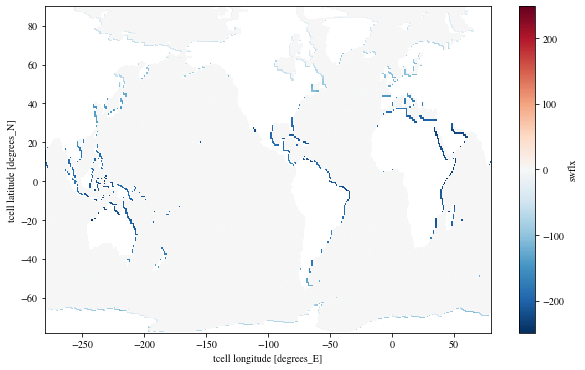

In [7]:
plt.figure(figsize = (10, 6))

var_ffa2 = cc.querying.getvar(expt = expt[0], session = session[0], variable = j, frequency = '1 daily').mean('time')
var_cont = cc.querying.getvar(expt = expt[1], session = session[1], variable = j, frequency = '1 monthly').mean('time')
(var_ffa2 - var_cont).plot()